<a href="https://colab.research.google.com/github/smf-9000/kaggle/blob/main/%5B004_2%5D_lightGBM_and_ann_dataset_tps_sep_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config Completer.use_jedi = False

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
import scikitplot as skplt

import scipy.stats as stats

import lightgbm as lgb
import warnings

import optuna

In [ ]:
R_SEED = 37

#### Additional ann dataset
My excursion with neural net ended with bad result. In try to get something out of it, I collected data from layer before the last. So, version1 of this dataset has 32 features and version2 has 16 features. Dataset is [public](https://www.kaggle.com/ivankontic/0042-ann32ds-tps-sep-2021), if someone want to try.

In [ ]:
submission_ex = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv')
train_data_a = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/train.csv')
test_data_a  = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/test.csv')
train_data_b = pd.read_csv('/kaggle/input/0042-ann32ds-tps-sep-2021/train_data_nn_features.csv')
test_data_b  = pd.read_csv('/kaggle/input/0042-ann32ds-tps-sep-2021/test_data_nn_features.csv')

In [ ]:
target_data = train_data_a[['claim']].copy()
train_data_a.drop(['id', 'claim'], axis=1, inplace=True)
submit_data = test_data_a[['id']].copy()
test_data_a.drop(['id'], axis=1, inplace=True)

In [ ]:
all_data = pd.concat([train_data_a, test_data_a])
all_data.reset_index(drop=True, inplace=True)

In [ ]:
all_n_missing = all_data.isna().sum(axis=1)
all_std = all_data.std(axis=1)

In [ ]:
all_data_normalized = StandardScaler().fit_transform(all_data)
all_data = pd.DataFrame(all_data_normalized, columns=all_data.columns)

I decided to not do anything with missing values (for now). Let lgbm deal with it.

In [ ]:
##### all_data['n_missing'] = all_n_missing
##### all_data['std'] = all_std

# imputer = SimpleImputer(strategy='constant', fill_value=0) # add_indicator=True, 

# old_features = list(all_data.columns)
# all_data = pd.DataFrame(imputer.fit_transform(all_data))
# features = old_features # + ['ind_for_' + str(e) for e in imputer.indicator_.features_]
# all_data.columns = features

In [ ]:
train_data_a, test_data_a = all_data.iloc[:train_data_a.shape[0],:].copy(), all_data.iloc[train_data_a.shape[0]:,:].copy()

n_missing = all_n_missing[:train_data_a.shape[0]]

#### Just experimenting
Maybe some of pca components will be useful. PCA has been applied on ann dataset.

In [ ]:
pca = PCA(n_components=5)
pca.fit(pd.concat([train_data_b, test_data_b]))
train_data_c = pd.DataFrame(pca.transform(train_data_b), columns=['pca_b_f' + str(i) for i in range(5)])
test_data_c = pd.DataFrame(pca.transform(test_data_b), columns=['pca_b_f' + str(i) for i in range(5)])

In [ ]:
print(pca.explained_variance_ratio_)

[0.8860344  0.0414131  0.01112924 0.00961131 0.00804676]


#### NaN

In [ ]:
def plot_gmm(model, data, ax, c):
    weights = model.weights_
    means = model.means_
    covars = model.covariances_

    x = np.arange(np.min(data), np.max(data), (np.max(data) - np.min(data)) / 100)
    for i in range(len(weights)):
        ax.plot(x - 1, weights[i] * stats.norm.pdf(x,means[i],np.sqrt(covars[i])[0]), alpha = 0.7, linewidth = 3, color=c)

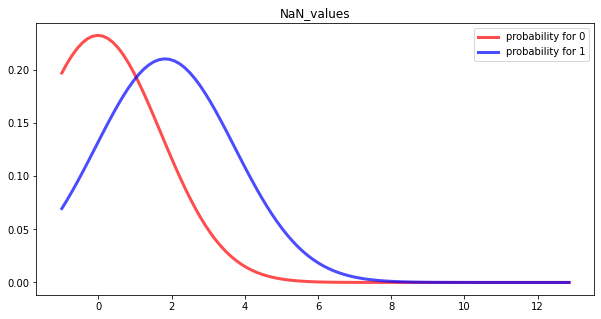

In [ ]:
fig = plt.figure(figsize = (10, 5))
ax = fig.gca()

data0 = np.expand_dims(n_missing[target_data['claim'] == 0], axis=1)
gm = GaussianMixture(n_components = 1, n_init = 5)
gm.fit(data0)
plot_gmm(gm, data0, ax, 'red')
#---
data1 = np.expand_dims(n_missing[target_data['claim'] == 1], axis=1)
gm = GaussianMixture(n_components = 1, n_init = 5)
gm.fit(data1)
plot_gmm(gm, data1, ax, 'blue')

ax.set_title('NaN_values')
ax.legend(['probability for 0', 'probability for 1'])

plt.show()

Little more freely drawn graph, but it should be right.  
As we can see, if there are NaN in row, probability is on the side of 1s. I'll try later something with this probabilities.

In [ ]:
train_data = pd.concat([train_data_a, train_data_b, train_data_c], axis=1)
test_data = pd.concat([test_data_a.reset_index(drop=True), test_data_b, test_data_c], axis=1)

In [ ]:
del train_data_a, train_data_b, train_data_c, test_data_a, test_data_b, test_data_c, all_data

#### Run
Two models are trained, One on prepared dataset and one on number_of_missing array.  
Just want to see how looks on graph.

In [ ]:
params_1 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 20000,
    'learning_rate': 0.005,
    'num_leaves': 627, 
    'min_child_samples': 1952, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'importance_type': 'gain'}

params_2 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000, 
    'learning_rate': 0.05, 
    'num_leaves': 89, 
    'min_child_samples': 48, 
    'feature_fraction': 0.35, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 1}
    
model_1 = lgb.LGBMRegressor(**params_1,
                          n_jobs=-1,
                          random_state = R_SEED)

model_2 = lgb.LGBMRegressor(**params_2,
                          n_jobs=-1,
                          random_state = R_SEED)

In [ ]:
kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = R_SEED)
pred = []
lgb_oof_1 = np.zeros(train_data.shape[0])
lgb_oof_2 = np.zeros(train_data.shape[0])

for train_index, test_index in kfolds.split(X=train_data, y=n_missing):

    X_train, X_val = train_data.iloc[train_index], train_data.iloc[test_index]
    X_train_2, X_val_2 = np.expand_dims(n_missing[train_index], axis=1), np.expand_dims(n_missing[test_index], axis=1)
    y_train, y_val = target_data.iloc[train_index], target_data.iloc[test_index]
    
    print(y_train.shape[0], y_train['claim'].sum())
    
    model_1.fit(
        X_train, 
        np.ravel(y_train), 
        eval_metric = "auc", 
        eval_set = [(X_val, y_val)],
        verbose = 100,
        early_stopping_rounds = 500)
    
    oof_pred_1 = model_1.predict(X_val)
    lgb_oof_1[test_index] = oof_pred_1
        
    _p = model_1.predict(test_data)
    pred.append(_p)
    
    model_2.fit(
        X_train_2, 
        np.ravel(y_train), 
        eval_metric = "auc", 
        eval_set = [(X_val_2, y_val)],
        verbose = 100,
        early_stopping_rounds = 200)
    
    oof_pred_2 = model_2.predict(X_val_2)
    lgb_oof_2[test_index] = oof_pred_2
    
final_p = np.sum(pred, axis = 0) / len(pred)

submit_data['claim'] = final_p
submit_data.to_csv('submission.csv', index=False)

766335 382156
Training until validation scores don't improve for 500 rounds
[100]	valid_0's auc: 0.808082
[200]	valid_0's auc: 0.808801
[300]	valid_0's auc: 0.809377
[400]	valid_0's auc: 0.810016
[500]	valid_0's auc: 0.810579
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.810579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.798861
[200]	valid_0's auc: 0.798861
Early stopping, best iteration is:
[13]	valid_0's auc: 0.798862
766335 382004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature

Curve is drawn with oof data

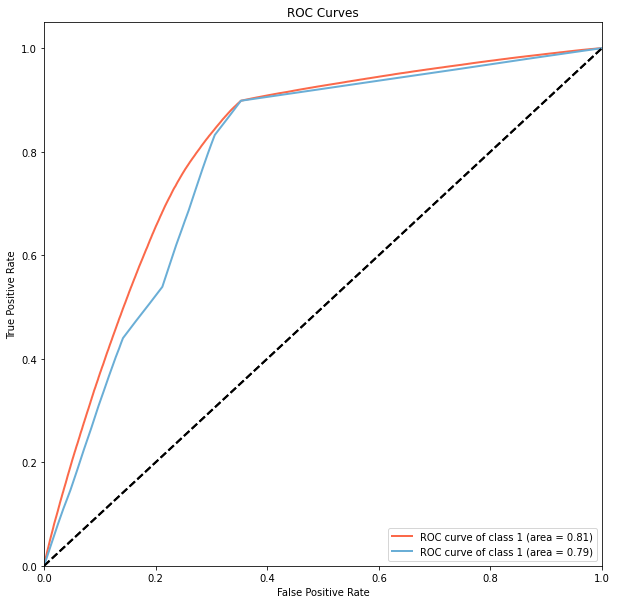

In [ ]:
p_1 = [(1-e, e) for e in lgb_oof_1]
p_2 = [(1-e, e) for e in lgb_oof_2]

fig = plt.figure(figsize = (10, 10))
ax = fig.gca()

skplt.metrics.plot_roc(target_data.claim.values, p_1, plot_micro=False, plot_macro=False, classes_to_plot=[1], ax=ax, cmap='Reds')
# skplt.metrics.plot_roc(target_data.claim.values, p_1, plot_micro=False, plot_macro=False, classes_to_plot=[0], ax=ax, cmap='ocean')
skplt.metrics.plot_roc(target_data.claim.values, p_2, plot_micro=False, plot_macro=False, classes_to_plot=[1], ax=ax, cmap='Blues')
plt.show()

It seems a bit unnatural :). The blue one is of number_of_missing "dataset".  
left side is a bit to spacious. It's sign that we have in upper side mixing of 1s and 0s. So, part closer to 0 is better than part closer to 1 (as far as classification is concerned)